In [ ]:
!pip install "gymnasium[mujoco]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 142.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 29.2 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import numpy as np

class SteerableWalkerWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        original_shape = env.observation_space.shape[0]

        # 3 objectives
        self.num_objectives = 3

        # Observation = State(17) + Preference(3) = 20
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(original_shape + self.num_objectives,),
            dtype=np.float32
        )
        # initialize (w1, w2, w3)
        self.current_w = np.array([0.33, 0.33, 0.33], dtype=np.float32)

    def reset(self, seed=None, options=None):
        # If you have already trained the agent and want to test
        # it specifically for "Energy Efficiency," you would pass
        # options={'w': [0.0, 0.0, 1.0]}
        if options and 'w' in options:
            self.current_w = np.array(options['w'], dtype=np.float32)
        else:
            # This branch runs during training.
            # random sample weight and normalize
            w = np.random.rand(self.num_objectives)
            self.current_w = w / w.sum()

        obs, info = self.env.reset(seed=seed)
        return np.concatenate([obs, self.current_w]), info

    def step(self, action):
        obs, _, terminated, truncated, info = self.env.step(action)

        # get 3 rewards
        # Forward Reward
        r_velocity = info.get('reward_forward', 0.0)

        # Healthy Reward
        r_survive = info.get('reward_survive', 0.0)

        # Control Cost
        # Gym returns positive so we optimize the optimization objective (maximize -cost)
        r_energy = -info.get('reward_ctrl', 0.0)

        # resemble into 3d vector
        vec_reward = np.array([r_velocity, r_survive, r_energy], dtype=np.float32)

        # save info for Variant B/C
        info['vec_reward'] = vec_reward

        # Scalar = w1*Vel + w2*Survive + w3*Energy
        weighted_scalar_reward = np.dot(self.current_w, vec_reward)

        new_obs = np.concatenate([obs.astype(np.float32), self.current_w]).astype(np.float32)

        return new_obs, weighted_scalar_reward, terminated, truncated, info

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal

# ==========================================
# 2. Continuous Scalar Agent (Variant A)
# ==========================================

# Instead of random noise, this initializes the weights so that the layers are
# mathematically "perpendicular" to each other. This is a standard PPO trick to
# prevent gradients from exploding or vanishing early in training.

def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class ContinuousScalarAgent(nn.Module):
    def __init__(self, env):
        super().__init__()
        # Observation = 17 (state) + 3 (weights) = 20
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0] # Walker2d = 6

        # === Critic (Scalar Output) ===
        # Critic looks at the current state (17) and current weights (3)
        # and predict a single number: the expected total reward.
        self.critic = nn.Sequential(
            layer_init(nn.Linear(obs_dim, 64)),
            nn.Tanh(), # introduce non-linearity
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )

        # === Actor (Continuous Mean) ===
        # Variant A: Actor just predict a mean vector (same as variant B)
        # predicts the average torque for each joint
        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(obs_dim, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, action_dim), std=0.01),
        )
        self.actor_logstd = nn.Parameter(torch.zeros(1, action_dim))

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        # Input 'x' is [Batch_Size, 20] (State + Preferences).
        # actor_mean is the Neural Network that predicts the target torque for each joint.
        # Output 'action_mean' shape: [Batch_Size, 6] (6 joints in Walker2d).
        action_mean = self.actor_mean(x)

        # self.actor_logstd is a single learnable row of [1, 6].
        # expand_as(action_mean) "copies" that row for every walker in the batch.
        # Output 'action_logstd' shape: [Batch_Size, 6].
        action_logstd = self.actor_logstd.expand_as(action_mean)

        # We store Log-Std to allow the optimizer to work in an unconstrained range (-inf, +inf).
        # torch.exp() maps the Log-Std back to a standard deviation (sigma) that is ALWAYS > 0.
        # Output 'action_std' shape: [Batch_Size, 6].
        action_std = torch.exp(action_logstd)

        # Normal() creates a Gaussian distribution for every joint in every batch scenario.
        # This object 'probs' allows us to sample random actions and calculate their likelihood.
        # It takes [Batch_Size, 6] for both mean and std.
        probs = Normal(action_mean, action_std)


        # During 'Rollout' (collecting data), action is None, so we sample.
        # During 'Update' (training), we pass the specific action taken back in to re-calculate math.
        # action.sample() picks a random torque value based on the Mean and Std Dev.
        # Output 'action' shape: [Batch_Size, 6].
        if action is None:
            action = probs.sample()

        # probs.log_prob(action) finds the log-probability of each joint torque [Batch_Size, 6].
        # .sum(1) adds the logs of all 6 joints to get the "Full Body" log-probability.
        # Multi-Joint probability P(A,B) = P(A)*P(B), which in log space is log(A) + log(B).
        # Output 'log_prob' shape: [Batch_Size].
        log_prob = probs.log_prob(action).sum(1)

        # Since we assume the 6 joints are independent in our distribution,
        # probs.entropy() calculates the "width" of the distribution for each joint [Batch_Size, 6].
        # .sum(1) gives the total entropy for the entire 6-joint system.
        # Higher entropy means the agent is more "curious" and taking more diverse actions.
        # Output 'entropy' shape: [Batch_Size].
        entropy = probs.entropy().sum(1)

        return action, log_prob, entropy, self.critic(x)

# ==========================================
# 3. Main Training Loop
# ==========================================
if __name__ == "__main__":
    # === Hyperparameters ===
    learning_rate = 3e-4
    num_steps = 2048
    total_timesteps = 1000000
    gamma = 0.99
    gae_lambda = 0.95
    update_epochs = 10
    clip_coef = 0.2
    ent_coef = 0.0
    vf_coef = 0.05
    max_grad_norm = 0.5
    batch_size = 64

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize  - the agent sees the 20-dim observation (State + Preference weights).
    env = SteerableWalkerWrapper(gym.make("Walker2d-v5"))

    # use Scalar Agent
    agent = ContinuousScalarAgent(env).to(device)
    # handing the optimizer a "pointer" to every weight and bias in your Actor and Critic
    optimizer = optim.Adam(agent.parameters(), lr=learning_rate)

    # Initialize Buffers
    # Stores the 20-dimensional observations [2048, 20].
    obs = torch.zeros((num_steps, env.observation_space.shape[0])).to(device)

    # Stores the 6 torques applied to the joints [2048, 6]
    actions = torch.zeros((num_steps, env.action_space.shape[0])).to(device)

    # Stores the likelihood of each action taken [2048]
    logprobs = torch.zeros((num_steps,)).to(device)

    # Variant A: Rewards and Values are Scalar
    rewards = torch.zeros((num_steps,)).to(device)
    # save (Velocity, Survive, Energy) reward
    vec_rewards = torch.zeros((num_steps, 3)).to(device)

    # At Step 10, the Critic looks at the walker and says,
    # "I expect you'll get 50 more points before you fall." We save that 50.0 into values[10].
    values = torch.zeros((num_steps,)).to(device)

    # Most of the time, this buffer is full of 0.0.
    # But if the walker fell at Step 500, dones[501] will be 1.0
    dones = torch.zeros((num_steps,)).to(device)

    global_step = 0
    # Resets the env to get the first 20-dim observation.
    next_obs, _ = env.reset()
    # Converts the NumPy array from Gym into a PyTorch tensor for the network.
    next_obs = torch.tensor(next_obs, dtype=torch.float32, device=device)  # (20,)
    # 'next_done' starts at 0.0 because the walker is currently standing.
    next_done = torch.tensor(0.0).to(device)

    # Calculates how many times we will perform a PPO update
    # (total steps / steps per rollout).
    num_updates = total_timesteps // num_steps

    print(f"Starting Walker2d Training (Variant A)... Target: {total_timesteps} steps")

    # OUTER LOOP: One 'update' consists of collecting
    # 2048 steps and then training on them.
    for update in range(1, num_updates + 1):

        # 1. Rollout
        # Inner Loop: Collecting a fixed amount
        # of experience (num_steps = 2048).
        for step in range(num_steps):
            global_step += 1

            # SAVE CURRENT STATE: Store the observation (17 body + 3 weight) and the done flag.
            # obs[step] is shape [20], dones[step] is scalar.
            obs[step] = next_obs

            # INFERENCE MODE: Disable gradient tracking to save memory/speed while just acting.
            with torch.no_grad():
                # UNSQUEEZE(0): Changes (20,) to (1, 20) because the network expects a "Batch" dimension.
                # 'value' here is the Critic's prediction of future reward for this state.
                # Calculated by the neural network on the GPU.
                action, logprob, _, value = agent.get_action_and_value(next_obs.unsqueeze(0))

                # squeeze back to save into buffer / step env
                # SQUEEZE(0): Removes the batch dimension to return to raw vectors for the environment.
                action = action.squeeze(0)      # (6,)
                logprob = logprob.squeeze(0)    # scalar tensor

                # strictly based on the observation state and has nothing to do with the specific action
                # being taken at that moment.
                value = value.squeeze(0)        # (1,)

                values[step] = value.flatten()[0]

            # Saved in the GPU buffer for the PPO update later.
            actions[step] = action
            logprobs[step] = logprob

            # PHYSICAL INTERACTION: Apply action just saved to actions[step]
            # action.cpu().numpy() converts the GPU tensor back to a CPU NumPy array for Gym.
            # env.step needs numpy (6,)
            real_next_obs, scalar_reward, terminated, truncated, info = env.step(action.cpu().numpy())

            # True if the walker falls over/have a max_episode_steps(set by the original environment creator)
            done = terminated or truncated

            rewards[step] = torch.tensor(scalar_reward, device=device, dtype=torch.float32)
            # True as 1.0 and False as 0.0
            dones[step] = torch.tensor(float(done), device=device)

            # save vec reward into buffer
            vec_rewards[step] = torch.tensor(info["vec_reward"], device=device, dtype=torch.float32)

            # If fall over, just save the reset obs as next_obs and save 0.0 as next_done
            if done:
                next_obs_np, _ = env.reset()
                next_obs = torch.tensor(next_obs_np, dtype=torch.float32, device=device)  # still (20,)
            else:
               # next_obs keeps (20,)
               # next_obs = real_next_obs
               # When the loop restarts, the new obs[step] is actually the old real_next_obs/next_obs.
                next_obs = torch.tensor(real_next_obs, dtype=torch.float32, device=device)

        # 2. Standard Scalar GAE (after 2048 steps finished)
        # 'next_obs' is the state the walker is currently in at the end of the 2048 steps.
        # We need the Critic's prediction of this state's value to calculate the "remainder" of the rewards.
        with torch.no_grad():
            # next_value shape: [1, 1]
            # next_done = the last element in done, done[2047]
            next_done = dones[-1]
            # next_obs is effectively the 2049th observation (or obs[2048] if we followed zero-indexing)
            # It takes that final observation and outputs a prediction of all future rewards the walker will get from that point on
            next_value = agent.get_value(next_obs).reshape(1, -1)

            # Create an empty tensor to store the calculated advantages for all 2048 steps.
            advantages = torch.zeros_like(rewards).to(device)

            # keeps track of the "accumulated" advantage as we loop backwards.
            lastgaelam = 0

            # We loop from the LAST step to the FIRST step (reversed).
            # t = 2047, ...,0
            for t in reversed(range(num_steps)):
                # Handle the final step edge case
                if t == num_steps - 1:
                    # nextnonterminal is 0.0 if the walker fell on the very last step, 1.0 otherwise.
                    nextnonterminal = 1.0 - next_done
                    nextvalues = next_value
                else:
                    # Check if the walker fell in the NEXT step.
                    nextnonterminal = 1.0 - dones[t]
                    nextvalues = values[t + 1]

                # CALCULATE THE TD-ERROR (Delta)
                # Delta = [Immediate Reward] + [Discounted Future Value] - [What we Predicted]
                # If Delta is positive, the action was BETTER than the Critic expected.
                # If Delta is negative, the action was WORSE.
                # nextvalue = the Critic thinks you will get from now until the end of time, starting from the next position.
                # value = What the Critic predicted you would get before you even took the action (the average value of the state)
                # gamma: how much you care about the future
                # done => nextnonterminal = 0, future advantage is cut off, only current reward
                delta = rewards[t] + gamma * nextvalues * nextnonterminal - values[t]

                # CALCULATE THE ACCUMULATED ADVANTAGE
                # This formula blends the current Delta with all future Deltas.
                # 'gae_lambda' determines how much we trust our future predictions vs. the immediate reward.
                lastgaelam = delta + gamma * gae_lambda * nextnonterminal * lastgaelam
                advantages[t] = lastgaelam

            # CALCULATE THE "RETURN"
            # The 'return' is what the Critic should have predicted.
            # We use this to train the Critic network later (Value Loss).
            # Advantage is a hindsight correction signal computed from real rollout data.
            # advantage > 0 : the action performed better than critic expected
            # advantage < 0 : the action performed worse than critic expected

            # Returns are a post-hoc estimate of the true long-term discounted reward.
            # They represent what the critic SHOULD have predicted at that state.
            returns = advantages + values

        # 3. Standard PPO Update
        # Flatten rollout buffers into training batches (single-env: num_steps samples)
        b_obs = obs.reshape((-1, env.observation_space.shape[0])) # [T, obs_dim]
        b_logprobs = logprobs.reshape(-1) # [T]
        b_actions = actions.reshape((-1, env.action_space.shape[0])) # [T, act_dim]
        b_advantages = advantages.reshape(-1) # [T]
        b_returns = returns.reshape(-1) # [T]
        b_values = values.reshape(-1) # [T]

        # Indices for shuffling and mini-batch sampling
        b_inds = np.arange(num_steps) # [0..T-1]

        for epoch in range(update_epochs):
            # shuffle sample order each epoch
            np.random.shuffle(b_inds)

            # Iterate mini-batches
            for start in range(0, num_steps, batch_size):
                end = start + batch_size
                mb_inds = b_inds[start:end]

                # Recompute logprob/value under the CURRENT policy for the SAME actions
                _, newlogprob, entropy, newvalue = agent.get_action_and_value(b_obs[mb_inds], b_actions[mb_inds])

                # PPO ratio: pi_new(a|s) / pi_old(a|s) computed in log-space for stability
                logratio = newlogprob - b_logprobs[mb_inds]  # [B]
                ratio = logratio.exp() # [B]

                # Normalize advantages (variance reduction / training stability)
                mb_adv = b_advantages[mb_inds] # [B]
                mb_adv = (mb_adv - mb_adv.mean()) / (mb_adv.std() + 1e-8) # [B]

                # Policy gradient loss (unclipped)
                pg_loss1 = -mb_adv * ratio # [B]

                # Policy gradient loss (clipped ratio to prevent too-large updates)
                pg_loss2 = -mb_adv * torch.clamp(ratio, 1 - clip_coef, 1 + clip_coef) # [B]

                # PPO clipped objective: take the pessimistic (max loss) version
                pg_loss = torch.max(pg_loss1, pg_loss2).mean()  # scalar

                # Value Loss (Scalar MSE)
                # Value function loss: fit V(s) to the computed returns (critic target)
                v_loss = 0.5 * ((newvalue.view(-1) - b_returns[mb_inds]) ** 2).mean() # scalar

                # Total loss: policy loss + value loss (and optional entropy bonus)
                loss = pg_loss - ent_coef * entropy.mean() + vf_coef * v_loss

                # Backprop + gradient clip + optimizer step
                optimizer.zero_grad() # clear old gradients
                loss.backward() # compute gradients
                nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm) # prevent exploding grads
                optimizer.step() # update actor+critic params

        if update % 10 == 0:
            v_m = vec_rewards.mean(dim=0) # [Vel, Surv, Ener]
            w_m = obs[:, -3:].mean(dim=0)
            weighted_reward = (v_m * w_m).sum().item()

            print(f"Update {update}/{num_updates} | Loss: {loss.item():.4f} | V_Loss: {v_loss.item():.4f}")
            print(f"  --> Weighted Reward: {weighted_reward:.2f}")
            print(f"  --> Component Rewards: [Vel: {v_m[0]:.2f}, Surv: {v_m[1]:.2f}, Ener: {v_m[2]:.2f}]")
            print(f"  --> Avg Weights: [W_vel: {w_m[0]:.2f}, W_surv: {w_m[1]:.2f}, W_ener: {w_m[2]:.2f}]")

    print("Training Finished (Variant A)!")
    torch.save(agent.state_dict(), "walker_variant_a_scalar_updated.pth")

Using device: cpu
Starting Walker2d Training (Variant A)... Target: 1000000 steps
Update 10/488 | Loss: 0.1862 | V_Loss: 4.4002
  --> Weighted Reward: 0.14
  --> Component Rewards: [Vel: -0.56, Surv: 0.97, Ener: 0.01]
  --> Avg Weights: [W_vel: 0.34, W_surv: 0.34, W_ener: 0.32]
Update 20/488 | Loss: 0.6251 | V_Loss: 13.3295
  --> Weighted Reward: 0.29
  --> Component Rewards: [Vel: -0.09, Surv: 0.99, Ener: 0.01]
  --> Avg Weights: [W_vel: 0.29, W_surv: 0.32, W_ener: 0.39]
Update 30/488 | Loss: 0.3266 | V_Loss: 7.5308
  --> Weighted Reward: 0.56
  --> Component Rewards: [Vel: 0.45, Surv: 0.99, Ener: 0.01]
  --> Avg Weights: [W_vel: 0.34, W_surv: 0.40, W_ener: 0.25]
Update 40/488 | Loss: 0.1122 | V_Loss: 3.3004
  --> Weighted Reward: 0.58
  --> Component Rewards: [Vel: 0.54, Surv: 0.99, Ener: 0.01]
  --> Avg Weights: [W_vel: 0.29, W_surv: 0.42, W_ener: 0.29]
Update 50/488 | Loss: 0.1440 | V_Loss: 4.1619
  --> Weighted Reward: 0.60
  --> Component Rewards: [Vel: 0.73, Surv: 0.99, Ener: 0.

In [ ]:
import csv
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal

# ==========================================
# 2. Continuous Vector-Critic Agent
# ==========================================
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class ContinuousVectorAgent(nn.Module):
    def __init__(self, env, num_objectives):
        super().__init__()
        # Observation = 17 (state) + 3 (weights) = 20
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0] # Walker2d = 6

        self.num_objectives = num_objectives

        # === Critic (Vector Output) ===
        # output dimension = 3 (Vel, Survive, Energy)
        self.critic = nn.Sequential(
            layer_init(nn.Linear(obs_dim, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, num_objectives), std=1.0),
        )

        # === Actor (Continuous Mean) ===
        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(obs_dim, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, action_dim), std=0.01),
        )
        # Learnable Log Std
        self.actor_logstd = nn.Parameter(torch.zeros(1, action_dim))

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        action_mean = self.actor_mean(x)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)

        probs = Normal(action_mean, action_std)

        if action is None:
            action = probs.sample()

        # continuous action space,we need to sum up log_prob in all dimensions
        log_prob = probs.log_prob(action).sum(1)
        entropy = probs.entropy().sum(1)

        return action, log_prob, entropy, self.critic(x)

In [ ]:
# NOTE:
# This Transformer mixer has no explicit supervision objective and does not
# take the environment state as input. Its only training signal comes from
# the PPO policy loss (pg_loss).
#
# As a result, the mixer is implicitly trained to produce a scalarized
# advantage that makes pg_loss smaller, i.e., yields policy updates that are
# easier, more stable, or more effective for improving training performance.
#
# However, this does NOT guarantee that:
#   - the mixer respects the user-specified preference vector w, or
#   - the learned mixing weights alpha are consistent with w.
#
# In practice, alpha may reflect optimization convenience rather than
# the intended preference semantics.

class TransformerMixer(nn.Module):
    def __init__(self, d_model=32, nhead=4, num_layers=1):
        super().__init__()
        # each token feature = [adv_k, w_k]
        self.in_proj = nn.Linear(2, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.out_proj = nn.Linear(d_model, 1)  # per-token logit

    def forward(self, advantages, contexts):
        # advantages, contexts: [B, 3]
        # build 3 tokens: each token features = [adv_k, w_k]
        feats = torch.stack(
            [
                torch.stack([advantages[:, 0], contexts[:, 0]], dim=-1),
                torch.stack([advantages[:, 1], contexts[:, 1]], dim=-1),
                torch.stack([advantages[:, 2], contexts[:, 2]], dim=-1),
            ],
            dim=1,
        )  # [B, 3, 2]
        x = self.in_proj(feats)  # [B, 3, d_model]
        x = self.encoder(x)  # [B, 3, d_model]
        logits = self.out_proj(x).squeeze(-1)  # [B, 3]
        alpha = torch.softmax(logits, dim=-1)  # [B, 3]
        # scalar advantage = sum_k alpha_k * adv_k
        scalar_adv = (alpha * advantages).sum(dim=-1)  # [B]
        return scalar_adv, alpha

In [ ]:

# ==========================================
# 3. Main Training Loop (Variant B)
# ==========================================
if __name__ == "__main__":
    learning_rate = 3e-4
    num_steps = 2048
    total_timesteps = 1000000
    gamma = 0.99
    gae_lambda = 0.95
    update_epochs = 10
    clip_coef = 0.2
    ent_coef = 0.0
    vf_coef = 0.5
    max_grad_norm = 0.5
    batch_size = 64

    num_objectives=3

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize Env
    env = SteerableWalkerWrapper(gym.make("Walker2d-v5"), num_objectives)

    agent = ContinuousVectorAgent(env, num_objectives).to(device)
    optimizer = optim.Adam(agent.parameters(), lr=learning_rate)

    mixer = TransformerMixer(d_model=32, nhead=4, num_layers=1).to(device)
    mixer_optimizer = optim.Adam(mixer.parameters(), lr=1e-4)


    log_file_path = "results_variant_b.csv"
    with open(log_file_path, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["update", "global_step", "weighted_reward", "vel", "surv", "ener"])

    # Initialize Buffers
    # Obs include weight
    obs = torch.zeros((num_steps, env.observation_space.shape[0])).to(device)
    # Action is a vector [num_steps, 6]
    actions = torch.zeros((num_steps, env.action_space.shape[0])).to(device)
    logprobs = torch.zeros((num_steps,)).to(device)

    # Rewards/Values returns [num_steps, 3]
    rewards = torch.zeros((num_steps, num_objectives)).to(device)
    values = torch.zeros((num_steps, num_objectives)).to(device)

    dones = torch.zeros((num_steps,)).to(device)
    contexts = torch.zeros((num_steps, num_objectives)).to(device) # save weights

    global_step = 0
    next_obs, _ = env.reset()
    next_obs = torch.tensor(next_obs, dtype=torch.float32, device=device)
    next_done = torch.tensor(0.0, device=device)

    num_updates = total_timesteps // num_steps

    print(f"Starting Walker2d Training (Variant B)... Target: {total_timesteps} steps")

    for update in range(1, num_updates + 1):

        # 1. Rollout Phase
        for step in range(num_steps):
            global_step += 1
            obs[step] = next_obs
            # save current weights w (Observation - last 3 position)
            contexts[step] = next_obs[-num_objectives:]

            with torch.no_grad():
                action, logprob, _, value = agent.get_action_and_value(next_obs.unsqueeze(0))

                action = action.squeeze(0)     # (6,)
                logprob = logprob.squeeze(0)   # scalar
                value = value.squeeze(0)       # (3,)

                values[step] = value

            actions[step] = action
            logprobs[step] = logprob

            # Step environment
            real_next_obs, _, terminated, truncated, info = env.step(action.cpu().numpy())

            # True if the walker falls over/have a max_episode_steps(set by the original environment creator)
            done = terminated or truncated

            # get vector Reward
            r_vec = info['vec_reward']
            rewards[step] = torch.tensor(r_vec, device=device, dtype=torch.float32)

            # True as 1.0 and False as 0.0
            dones[step] = torch.tensor(float(done), device=device)

            # If fall over, just save the reset obs as next_obs and save 0.0 as next_done
            if done:
                next_obs_np, _ = env.reset()
                next_obs = torch.tensor(next_obs_np, dtype=torch.float32, device=device)  # still (20,)
            else:
               # next_obs keeps (20,)
               # next_obs = real_next_obs
               # When the loop restarts, the new obs[step] is actually the old real_next_obs/next_obs.
                next_obs = torch.tensor(real_next_obs, dtype=torch.float32, device=device)

        # 2. Vector GAE Calculation
        with torch.no_grad():
            # next_done = the last element in done, done[2047]
            next_done = dones[-1]

            next_value = agent.get_value(next_obs) # [3] vector
            advantages = torch.zeros_like(rewards, device=device)
            lastgaelam = torch.zeros(num_objectives, device=device) # [3] vector

            # We loop from the LAST step to the FIRST step (reversed).
            # t = 2047, ...,0
            for t in reversed(range(num_steps)):
                if t == num_steps - 1:
                    nextnonterminal = 1.0 - next_done
                    nextvalues = next_value
                else:
                    nextnonterminal = 1.0 - dones[t]
                    nextvalues = values[t + 1]

                # Vector Delta
                delta = rewards[t] + gamma * nextvalues * nextnonterminal - values[t]
                advantages[t] = lastgaelam = delta + gamma * gae_lambda * nextnonterminal * lastgaelam

            returns = advantages + values

        # 3. Scalarization & PPO Update
        # Variant B: weighted sum of advantage
        # scalar_advantages shape: [num_steps]
        # scalar_advantages = (advantages * contexts).sum(dim=1)

        # Flatten batch
        b_obs = obs.reshape((-1, env.observation_space.shape[0]))
        b_logprobs = logprobs.reshape(-1)
        b_actions = actions.reshape((-1, env.action_space.shape[0]))
        #b_scalar_advantages = scalar_advantages.reshape(-1)
        b_returns = returns.reshape((-1, num_objectives))
        b_values = values.reshape((-1, num_objectives))

        # Mini-batch Update
        b_inds = np.arange(num_steps)

        for epoch in range(update_epochs):
            # shuffle sample order each epoch
            np.random.shuffle(b_inds)
            for start in range(0, num_steps, batch_size):
                end = start + batch_size
                mb_inds = b_inds[start:end]

                # recompute scalar advantages for this mini-batch via mixer
                mb_advantages = advantages[mb_inds]
                mb_contexts = contexts[mb_inds]
                scalar_adv_mb, _ = mixer(mb_advantages, mb_contexts)

                _, newlogprob, entropy, newvalue = agent.get_action_and_value(b_obs[mb_inds], b_actions[mb_inds])
                logratio = newlogprob - b_logprobs[mb_inds]
                ratio = logratio.exp()

                #mb_adv = b_scalar_advantages[mb_inds]
                mb_adv = scalar_adv_mb

                # Normalize Advantage
                mb_adv = (mb_adv - mb_adv.mean()) / (mb_adv.std() + 1e-8)

                # Policy Loss
                pg_loss1 = -mb_adv * ratio
                pg_loss2 = -mb_adv * torch.clamp(ratio, 1 - clip_coef, 1 + clip_coef)

                # torch.max(pg_loss1, pg_loss2) - shape == (B,) to each sample we take max
                # take the average among all dimensions
                pg_loss = torch.max(pg_loss1, pg_loss2).mean() #scalar

                # Vector critic value loss (Mean Squared Error)
                # newvalue: critic prediction, shape (batch_size, 3)
                # b_returns[mb_inds]: vector GAE return target, shape (batch_size, 3)
                # This computes the average MSE across:
                #   (1) the mini-batch dimension
                #   (2) the objective dimension (3 objectives)
                # No preference weights are applied here:
                # the critic learns to fit each objective equally,
                # while preference weighting is handled later in advantage scalarization.
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean() #scalar

                loss = pg_loss - ent_coef * entropy.mean() + vf_coef * v_loss

                optimizer.zero_grad()
                mixer_optimizer.zero_grad()
                loss.backward()
                # Gradient Clipping
                nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
                optimizer.step()
                mixer_optimizer.step()

        if update % 10 == 0:
                    v_m = rewards.mean(dim=0)
                    train_scalar_rewards = (rewards * contexts).sum(dim=1).mean().item()
                    with open(log_file_path, mode='a', newline='') as f:
                      writer = csv.writer(f)
                      writer.writerow([
                          update,
                          global_step,
                          train_scalar_rewards,
                          v_m[0].item(),
                          v_m[1].item(),
                          v_m[2].item()
                      ])

                    print(f"Update {update} | Loss: {loss.item():.4f} | Weighted: {train_scalar_rewards:.2f}")
                    print(f"  --> Components: [Vel: {v_m[0]:.2f}, Surv: {v_m[1]:.2f}, Ener: {v_m[2]:.2f}]")

    print("Training Finished!")
    torch.save(agent.state_dict(), "walker_variant_b_3obj.pth")

Using device: cuda
Starting Walker2d Training (Variant B)... Target: 1000000 steps
Update 10 | Loss: 13.4914 | Weighted: 0.08
  --> Components: [Vel: -0.37, Surv: 0.99, Ener: 0.01]
Update 20 | Loss: 9.4900 | Weighted: 0.36
  --> Components: [Vel: 0.11, Surv: 1.00, Ener: 0.01]
Update 30 | Loss: 6.4061 | Weighted: 0.46
  --> Components: [Vel: 0.46, Surv: 0.99, Ener: 0.01]



KeyboardInterrupt



In [ ]:
class NewtonSchulzIndependenceLoss(nn.Module):
    def __init__(self, ns_steps=5, kurtosis_weight=0.001):
        super().__init__()
        self.ns_steps = ns_steps
        self.kurtosis_weight = kurtosis_weight

    def _newton_schulz_inverse_sqrt(self, A):
        dim = A.shape[0]
        norm_A = torch.norm(A, p='fro')
        Y = A / norm_A
        I = torch.eye(dim, device=A.device, dtype=A.dtype)
        X = I.clone()

        # Iterate compute A^{-1/2}
        for _ in range(self.ns_steps):
            T = X @ (Y @ X)
            X = 0.5 * X @ (3.0 * I - T)
        return X / torch.sqrt(norm_A)

    def forward(self, G):
        """
        Input G: [Parameter_Dim, 3] (gradient matrix)
        """
        # calculate covariance matrix A = G^T @ G (3x3)
        A = G.t() @ G
        A = A + 1e-6 * torch.eye(3, device=G.device) # stablity

        # get W
        W = self._newton_schulz_inverse_sqrt(A)

        # Z = G @ W
        Z = G @ W

        z_mean = torch.mean(Z, dim=0, keepdim=True)
        z_std = torch.std(Z, dim=0, keepdim=True) + 1e-8
        z_standardized = (Z - z_mean) / z_std
        # in case Z ** 4 too large
        z_standardized = torch.clamp(z_standardized, -5.0, 5.0)

        # compute ICA Loss (Kurtosis) for each column
        # Z [P, 3]
        m4 = torch.mean(z_standardized ** 4, dim=0) # output [1,3]
        # log the loss just in case ica loss is too large in the total loss
        ica_loss = -torch.sum(torch.log(m4 + 1.0))

        return ica_loss * self.kurtosis_weight, Z, W

In [ ]:
class GradientAttentionSynthesizer(nn.Module):
    def __init__(self, state_dim, pref_dim, num_objectives, n_bins=100):

        super().__init__()
        self.n_bins = n_bins  # number of discrete "bins"/templates in the codebook (int)
        self.num_objectives = num_objectives # K = number of objectives (int), e.g., 3 for {Vel, Surv, Ener}

        # Query network (MLP): maps [state, preference] -> query embedding q
        # Input  : concat([state, pref]) with shape [state_dim + pref_dim]
        # Output : q with shape [32]
        self.query_net = nn.Sequential(
            nn.Linear(state_dim + pref_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

        # Key feature dimension derived from SVD outputs:
        # S has shape [K]
        # V has shape [K, K]  (in your code you treat it as V; flatten -> [K*K])
        # so concat([S, V.flatten]) has length K + K*K
        sv_dim = self.num_objectives + (self.num_objectives * self.num_objectives)

        # Key network: maps SVD features -> key embedding k
        # Input  : sv_feat with shape [1, sv_dim] = [1, K + K*K]
        # Output : k with shape [1, 32]
        self.key_net = nn.Sequential(
            nn.Linear(sv_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

        # Classifier: turns the fused latent representation into logits over bins
        # Input  : latent with shape [1, 32]
        # Output : logits with shape [1, n_bins]
        self.classifier = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, n_bins)
        )

        # Codebook: learnable bank of n_bins "weight templates"
        # Shape : [n_bins, K]
        # Each row is initialized to sum to 1 (via _init_codebook), but later it is still a learnable tensor.
        self.codebook = nn.Parameter(self._init_codebook(n_bins, self.num_objectives), requires_grad=True)

    def _init_codebook(self, n_bins, num_objectives):
        # Randomly initialize the codebook with positive values
        # cb shape: [n_bins, K]
        cb = torch.rand(n_bins, num_objectives)

        # Normalize each row so that each template sums to 1 along the objective dimension
        # cb.sum(dim=-1, keepdim=True) shape: [n_bins, 1]
        # output cb shape: [n_bins, K], each row sums to 1
        return cb / cb.sum(dim=-1, keepdim=True)

    def forward(self, state, pref, S, V):
        # -----------------------------
        # Inputs (your current usage):
        # state: [state_dim]   (typically mb_obs_avg, averaged over minibatch)
        # pref : [pref_dim]    (typically mb_pref_avg, averaged over minibatch)
        # S    : [K]           (singular values from SVD)
        # V    : [K, K]        (right singular vectors matrix in your naming; flattened later)
        # -----------------------------

        # Concatenate state and preference to form query input
        # torch.cat([state, pref], dim=-1) shape: [state_dim + pref_dim]
        q_in = torch.cat([state, pref], dim=-1).unsqueeze(0)   # [state_dim + pref_dim]

        # Compute query embedding
        # q shape: [32]
        q = self.query_net(q_in)                  # [32]

        # Build SVD feature vector:
        # V.flatten() shape: [K*K]
        # torch.cat([S, V.flatten()], dim=-1) shape: [K + K*K] = [sv_dim]
        sv_feat_1d = torch.cat([S, V.flatten()], dim=-1)  # [sv_dim]

        # Add a batch dimension so it matches the key_net expected 2D input
        # sv_feat shape: [1, sv_dim]
        sv_feat = sv_feat_1d.unsqueeze(0)         # [1, sv_dim]

        # Compute key embedding
        # k shape: [1, 32]
        k = self.key_net(sv_feat)                 # [1, 32]

        # Fuse query and key:
        # q is [32], k is [1, 32]
        # Broadcasting happens: q is treated as [1, 32] during multiplication
        # latent shape: [1, 32]
        latent = q * k                            # [1, 32]

        # Produce logits over bins
        # logits shape: [1, n_bins]
        logits = self.classifier(latent)          # [1, n_bins]

        # Convert logits to a probability distribution over bins (soft selection of templates)
        # probs shape: [1, n_bins]
        probs = torch.softmax(logits / 0.8, dim=-1)  # [1, n_bins]

        # Enforce positivity of the codebook entries (your current design choice)
        # codebook shape: [n_bins, K] -> safe_codebook shape: [n_bins, K]
        safe_codebook = torch.nn.functional.softplus(self.codebook)  # [n_bins, K]

        # Weighted average of codebook templates:
        # probs: [1, n_bins]
        # safe_codebook: [n_bins, K]
        # alpha = probs @ safe_codebook -> [1, K]
        alpha = torch.matmul(probs, safe_codebook)  # [1, K]

        # Outputs:
        # alpha.squeeze(0) -> [K]   (a single K-dim mixture vector for this minibatch)
        # logits          -> [1, n_bins] (raw scores before softmax, used for training diagnostics/loss)
        return alpha.squeeze(0), logits

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
import csv

# ==========================================
# 3. Main Training Loop (Variant C: Gradient Mixing)
# ==========================================

def get_actor_grad_vector(agent):
    """
    Flatten and concatenate gradients of ALL actor parameters:
    - actor_mean network parameters
    - actor_logstd parameter

    Returns:
        1D tensor of shape [total_actor_params] (always the same length).
    """
    grads = []

    # Iterate over all actor params in a fixed order (mean params first, then logstd)
    for param in chain(agent.actor_mean.parameters(), [agent.actor_logstd]):

        # If this param has no grad (e.g., not involved in this backward pass),
        # append zeros to keep vector length/alignment consistent.
        if param.grad is None:
            grads.append(torch.zeros_like(param).view(-1))
        else:
            grads.append(param.grad.view(-1))

    return torch.cat(grads)

def set_actor_grad_vector(agent, grad_vector):
    """
    Assign a flattened 1D gradient vector back to all actor parameters.
    """
    pointer = 0
    # Tracks the current index inside the flat gradient vector.

    for param in chain(agent.actor_mean.parameters(), [agent.actor_logstd]):
        # Iterate over all actor parameters (mean network + logstd) in fixed order.

        numel = param.numel()
        # Number of elements in this parameter tensor.

        param.grad = grad_vector[pointer:pointer + numel].view_as(param).clone()
        # Take the corresponding slice from the flat vector,
        # reshape it to match the parameter shape, and assign as its gradient.

        pointer += numel
        # Move the pointer forward for the next parameter block.

if __name__ == "__main__":
    # === Hyperparameters ===
    learning_rate = 3e-4
    num_steps = 2048
    total_timesteps = 1000000
    gamma = 0.99
    gae_lambda = 0.95
    update_epochs = 10
    clip_coef = 0.2
    ent_coef = 0.0
    vf_coef = 0.05
    max_grad_norm = 0.5
    batch_size = 64
    ns_steps = 6
    kurtosis_weight = 0.1

    num_objectives=3

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize Env
    env = SteerableWalkerWrapper(gym.make("Walker2d-v5"), num_objectives)

    # Variant C also needs Vector Critic to estimate advantage of each objective seperately
    agent = ContinuousVectorAgent(env, num_objectives).to(device)
    optimizer = optim.Adam(agent.parameters(), lr=learning_rate)

    state_dim = env.observation_space.shape[0]
    synthesizer = GradientAttentionSynthesizer(
      state_dim=state_dim,
      pref_dim=num_objectives,
      num_objectives=num_objectives,
      n_bins=100).to(device)

    synth_optimizer = optim.Adam(synthesizer.parameters(), lr=1e-4)

    # ns
    # Given the gradient matrix G ∈ R^{d×3} (where each column is the actor gradient
    # for one objective), we first use the Newton–Schulz iteration to approximate
    # (G^T G)^(-1/2). This whitening transform decorrelates the three gradient
    # directions and produces a more orthogonal / independent basis Z.
    # We then apply a kurtosis-based (fourth-moment) ICA-style regularization term
    # to encourage the whitened components to be not only decorrelated but also
    # statistically independent.
    ica_criterion = NewtonSchulzIndependenceLoss(ns_steps= ns_steps, kurtosis_weight=kurtosis_weight).to(device)

    log_file_path = "results_variant_c_ica.csv"
    with open(log_file_path, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            "update", "global_step", "weighted_reward", "vel", "surv", "ener",
            "raw_cos_ve", "ica_cos_ve",
            "m4_vel", "m4_surv", "m4_ener",
            "synth_align"
        ])

    # Initialize Buffers
    obs = torch.zeros((num_steps, env.observation_space.shape[0])).to(device)
    actions = torch.zeros((num_steps, env.action_space.shape[0])).to(device)
    logprobs = torch.zeros((num_steps,)).to(device)

    # 3D Rewards & Values
    rewards = torch.zeros((num_steps, num_objectives)).to(device)
    values = torch.zeros((num_steps, num_objectives)).to(device)

    dones = torch.zeros((num_steps,)).to(device)
    # save context (weight)，using for calculation in loss
    contexts = torch.zeros((num_steps, num_objectives)).to(device)


    global_step = 0
    next_obs, _ = env.reset()
    next_obs = torch.tensor(next_obs, dtype=torch.float32, device=device)
    next_done = torch.tensor(0.0, device=device)

    num_updates = total_timesteps // num_steps

    cos_sim_01_list = []
    cos_sim_02_list = []
    cos_sim_12_list = []

    history_cos_01 = []
    history_cos_02 = []
    history_cos_12 = []

    history_singular_values = []

    history_weighted_rewards = []
    history_v_loss = []
    history_synth_loss = []

    m4_list = []
    raw_reward_vel_list = []
    raw_reward_sur_list = []
    raw_reward_ene_list = []
    weighted_reward_history = []

    ica_cos_ve_list = []
    synth_align_list = []

    print(f"Starting Walker2d Training (Variant C - ICA: Multi-Objective Gradient)...")

    for update in range(1, num_updates + 1):

        # 1. Rollout
        for step in range(num_steps):
            global_step += 1
            obs[step] = next_obs
            contexts[step] = next_obs[-num_objectives:]

            with torch.no_grad():
                action, logprob, _, value = agent.get_action_and_value(next_obs.unsqueeze(0))
                action = action.squeeze(0)     # (6,)
                logprob = logprob.squeeze(0)   # scalar
                value = value.squeeze(0)       # (3,)

                values[step] = value

            actions[step] = action
            logprobs[step] = logprob

            real_next_obs, _, terminated, truncated, info = env.step(action.cpu().numpy())
            done = terminated or truncated

            r_vec = info['vec_reward']
            raw_reward_vel_list.append(r_vec[0])
            raw_reward_sur_list.append(r_vec[1])
            raw_reward_ene_list.append(r_vec[2])

            current_weighted = (torch.tensor(r_vec, device=device) * contexts[step]).sum().item()
            weighted_reward_history.append(current_weighted)

            rewards[step] = torch.tensor(r_vec, device=device, dtype=torch.float32)

            # True as 1.0 and False as 0.0
            dones[step] = torch.tensor(float(done), device=device)

            # If fall over, just save the reset obs as next_obs and save 0.0 as next_done
            if done:
                next_obs_np, _ = env.reset()
                next_obs = torch.tensor(next_obs_np, dtype=torch.float32, device=device)  # still (20,)
            else:
               # next_obs keeps (20,)
               # next_obs = real_next_obs
               # When the loop restarts, the new obs[step] is actually the old real_next_obs/next_obs.
                next_obs = torch.tensor(real_next_obs, dtype=torch.float32, device=device)


        # 2. Vector GAE
        with torch.no_grad():

            # next_done = the last element in done, done[2047]
            next_done = dones[-1]

            next_value = agent.get_value(next_obs) # [3] vector
            advantages = torch.zeros_like(rewards, device=device)
            lastgaelam = torch.zeros(num_objectives, device=device) # [3] vector

            for t in reversed(range(num_steps)):
                if t == num_steps - 1:
                    nextnonterminal = 1.0 - next_done
                    nextvalues = next_value
                else:
                    nextnonterminal = 1.0 - dones[t]
                    nextvalues = values[t + 1]

                delta = rewards[t] + gamma * nextvalues * nextnonterminal - values[t]
                advantages[t] = lastgaelam = delta + gamma * gae_lambda * nextnonterminal * lastgaelam

            returns = advantages + values

        # 3. Variant C Special Update: Gradient Mixing
        # keep vector Advantage

        b_obs = obs.reshape((-1, env.observation_space.shape[0]))
        b_logprobs = logprobs.reshape(-1)
        b_actions = actions.reshape((-1, env.action_space.shape[0]))
        #?
        b_vector_advantages = advantages.reshape((-1, num_objectives)) # [Batch, 3]
        b_returns = returns.reshape((-1, num_objectives))
        b_contexts = contexts.reshape((-1, num_objectives))            # [Batch, 3]

        b_inds = np.arange(num_steps)

        for epoch in range(update_epochs):
            np.random.shuffle(b_inds)
            for start in range(0, num_steps, batch_size):
                end = start + batch_size
                mb_inds = b_inds[start:end]

                # --------------------------------------------------------
                # Recompute log-probabilities and value under CURRENT policy
                # for the SAME actions collected during rollout (all actions)
                # --------------------------------------------------------
                _, newlogprob, entropy, newvalue = agent.get_action_and_value(b_obs[mb_inds], b_actions[mb_inds])

                # Compute log ratio between new and old policy
                logratio = newlogprob - b_logprobs[mb_inds]

                # ratio = pi_theta(a|s) / pi_theta_old(a|s)
                ratio = logratio.exp()

                # Dictionary to store per-objective actor gradient vectors
                grad_vectors = {}

                # At the same parameter point θ, compute ∇_θ L^{(k)} for each objective k independently.
                # k=0: Vel, k=1: Surv, k=2: Ener

                # At the same parameter point θ, we compute a mini-batch PPO loss for each objective k.
                # The loss is averaged over all samples in the current mini-batch (size = batch_size).
                # Therefore, loss_k.backward() produces a single gradient vector ∇_θ L^{(k)}
                # that aggregates contributions from all (s, a_old) pairs in this mini-batch.
                # Each grad_vectors[k] is the batch-averaged actor gradient for objective k.
                for k in range(num_objectives):
                    # Extract advantage for objective k
                    adv_k = b_vector_advantages[mb_inds, k]

                    # Normalize advantages for numerical stability
                    adv_k = (adv_k - adv_k.mean()) / (adv_k.std() + 1e-8)

                    # PPO Loss
                    # ----------------------------------------------------
                    # PPO Clipped Surrogate Loss (per objective)
                    #
                    # We minimize the negative surrogate objective:
                    # max( -ratio * A, -clip(ratio) * A )
                    # ----------------------------------------------------
                    loss_k = torch.max(-adv_k * ratio, -adv_k * torch.clamp(ratio, 1 - clip_coef, 1 + clip_coef)).mean()

                    # Use autograd.grad and turn create_graph = TRUE
                    # which makes grad_vectors[k] to be a function of Actor's parameters
                    # We use torch.autograd.grad(..., create_graph=True) to obtain a differentiable
                    # gradient vector g_k(θ) with respect to the actor parameters. This allows the
                    # subsequent ICA-based independence loss to backpropagate through the gradient
                    # computation itself, enabling the model to actively learn gradient independence
                    # rather than performing a one-time numerical decomposition.
                    actor_params = list(chain(agent.actor_mean.parameters(), [agent.actor_logstd]))
                    grads = torch.autograd.grad(loss_k, actor_params, create_graph=True, retain_graph=True)
                    grad_vectors[k] = torch.cat([g.reshape(-1) for g in grads])

                # At the same parameter point θ, calculate entropy gradient

                # Compute entropy regularization gradient over the entire mini-batch.
                # entropy has shape [batch_size] - 64, one entropy value per state.
                # We take the mean over the batch, so backward() produces a single
                # gradient vector aggregated across all (s, a) pairs in this mini-batch.
                optimizer.zero_grad()
                entropy_loss = -ent_coef * entropy.mean()
                entropy_loss.backward(retain_graph=True)
                g_ent = get_actor_grad_vector(agent)
                # g0, g1, g2, g_ent lie in R^d, where d is the total number of actor parameters (actor_mean + actor_logstd).

                # ==========================================
                # Variant C-b: ICA
                # ==========================================
                if all(g is not None for g in grad_vectors.values()):
                    # gradient matrix

                    G = torch.stack([grad_vectors[k] for k in range(num_objectives)], dim=1)
                    # Normalize each column (each task gradient) to unit L2 norm by reducing along dim=0 (parameter dimension).
                    G_norm = G / (torch.norm(G, p=2, dim=0, keepdim=True) + 1e-8)

                    # Z: Whitened orthogonal basis [P, 3] (replacing the original U)
                    # W: Transformation matrix [3, 3] (replacing the original V-based logic)
                    ica_loss_val, Z, W = ica_criterion(G_norm)

                    # record current mini-batch m4
                    with torch.no_grad():
                        z_mean = torch.mean(Z, dim=0, keepdim=True)
                        z_std = torch.std(Z, dim=0, keepdim=True) + 1e-8
                        z_standardized_record = (Z - z_mean) / z_std
                        z_standardized_record = torch.clamp(z_standardized_record, -5.0, 5.0)
                        current_m4 = torch.mean(z_standardized_record ** 4, dim=0)
                        m4_list.append(current_m4.cpu().numpy())

                    # prepare mb_obs_avg mb_pref_avg
                    mb_obs_avg = b_obs[mb_inds].mean(dim=0)
                    mb_pref_avg = b_contexts[mb_inds].mean(dim=0)

                    # dummy_S (all 1) and W.flatten()
                    dummy_S = torch.ones(3).to(device)
                    alpha, synth_logits = synthesizer(mb_obs_avg, mb_pref_avg, dummy_S, W)

                    # alpha * U
                    g_task = torch.matmul(Z, alpha)

                    # add Entropy gradient
                    if g_ent is not None:
                        g_final_actor = g_task + g_ent
                    else:
                        g_final_actor = g_task


                    optimizer.zero_grad()
                    synth_optimizer.zero_grad()

                    # get Critic gradients (backward)
                    v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()
                    # add ica_loss into total loss and do backward
                    total_actor_critic_loss = vf_coef * v_loss + ica_loss_val
                    total_actor_critic_loss.backward(retain_graph=True)

                    torch.nn.utils.clip_grad_norm_(agent.actor_mean.parameters(), max_norm=0.05)

                     # train Synthesizer
                    with torch.no_grad():
                        target_g = torch.matmul(G, mb_pref_avg)

                    # we hope the direction of g_task to be as close as target_g
                    # alpha was produced by synthesizer and we'll get gradients for Synthesizer
                    cos_sim = torch.nn.functional.cosine_similarity(g_task.unsqueeze(0), target_g.unsqueeze(0))
                    synth_loss = 1.0 - cos_sim.mean()

                    with torch.no_grad():
                        czve = torch.nn.functional.cosine_similarity(Z[:, 0], Z[:, 2], dim=0)
                        ica_cos_ve_list.append(czve.item())
                        synth_align_list.append(cos_sim.mean().item())

                    synth_loss.backward()

                    # Actor gradient
                    set_actor_grad_vector(agent, g_final_actor)

                    # update together
                    nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
                    optimizer.step()

                    # Update Synthesizer
                    synth_optimizer.step()

                # calculate Cosine Similarity
                if all(g is not None for g in grad_vectors.values()):
                    # Vel vs Surv
                    cos_01 = torch.nn.functional.cosine_similarity(grad_vectors[0], grad_vectors[1], dim=0)
                    cos_sim_01_list.append(cos_01.item())
                    # Vel vs Ener
                    cos_02 = torch.nn.functional.cosine_similarity(grad_vectors[0], grad_vectors[2], dim=0)
                    cos_sim_02_list.append(cos_02.item())
                    # Surv vs Ener
                    cos_12 = torch.nn.functional.cosine_similarity(grad_vectors[1], grad_vectors[2], dim=0)
                    cos_sim_12_list.append(cos_12.item())

                    history_cos_01.append(cos_01)
                    history_cos_02.append(cos_02)
                    history_cos_12.append(cos_12)

        if update % 10 == 0:
            avg_weighted_reward = np.mean(weighted_reward_history)
            weighted_reward_history = []

            avg_cos_01 = np.mean(cos_sim_01_list) if cos_sim_01_list else 0
            avg_cos_02 = np.mean(cos_sim_02_list) if cos_sim_02_list else 0
            avg_cos_12 = np.mean(cos_sim_12_list) if cos_sim_12_list else 0
            cos_sim_01_list, cos_sim_02_list, cos_sim_12_list = [], [], []


            avg_ica_cos_ve = np.mean(ica_cos_ve_list) if ica_cos_ve_list else 0
            avg_synth_align = np.mean(synth_align_list) if synth_align_list else 0
            ica_cos_ve_list, synth_align_list = [], []
            avg_m4 = np.mean(m4_list, axis=0) if m4_list else [0, 0, 0]
            m4_list = []

            avg_raw_vel = np.mean(raw_reward_vel_list)
            avg_raw_sur = np.mean(raw_reward_sur_list)
            avg_raw_ene = np.mean(raw_reward_ene_list)
            raw_reward_vel_list, raw_reward_sur_list, raw_reward_ene_list = [], [], []


            with open(log_file_path, mode='a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow([
                    update, global_step, avg_weighted_reward,
                    avg_raw_vel, avg_raw_sur, avg_raw_ene,
                    avg_cos_02, avg_ica_cos_ve,
                    avg_m4[0], avg_m4[1], avg_m4[2],
                    avg_synth_align
                ])

            print(f"\n" + "="*60)
            print(f"UPDATE {update:03d} | Weighted Reward: {avg_weighted_reward:.3f}")
            print(f"  --> Raw Rewards: [Vel: {avg_raw_vel:.2f}, Surv: {avg_raw_sur:.2f}, Energy: {avg_raw_ene:.2f}]")
            print(f"  --> ICA Status : Loss: {ica_loss_val.item():.4f} | Alpha Sum: {alpha.sum().item():.2f}")
            print(f"  --> Kurtosis m4: [Vel: {avg_m4[0]:.2f}, Surv: {avg_m4[1]:.2f}, Ener: {avg_m4[2]:.2f}]")

            if len(history_singular_values) > 0:
                recent_S = np.array(history_singular_values[-10:])
                avg_S = np.mean(recent_S, axis=0)
                print(f"  --> Singular Val: [s1:{avg_S[0]:.4f}, s2:{avg_S[1]:.4f}, s3:{avg_S[2]:.4f}]")

            print(f"  --> CosSim Gap : [V/S: {avg_cos_01:.3f}] [V/E: {avg_cos_02:.3f}] [S/E: {avg_cos_12:.3f}]")
            print(f"  --> Alpha Mix  : {alpha.detach().cpu().numpy()}")
            print("="*60)

    print("Training Finished (Variant C)!")
    torch.save(agent.state_dict(), "walker_variant_c_grad.pth")


print("\n" + "="*50)
print("FINAL ALIGNMENT ANALYSIS (Last 10% of Training)")
num_final_samples = len(history_cos_01) // 10
if num_final_samples > 0:
        final_01 = np.mean(history_cos_01[-num_final_samples:])
        final_02 = np.mean(history_cos_02[-num_final_samples:])
        final_12 = np.mean(history_cos_12[-num_final_samples:])

        print(f"Final Average Vel/Surv CosSim: {final_01:.4f}")
        print(f"Final Average Vel/Ener CosSim: {final_02:.4f}")
        print(f"Final Average Surv/Ener CosSim: {final_12:.4f}")
print("="*50)

np.save("history_cos_01.npy", np.array(history_cos_01))
np.save("history_cos_02.npy", np.array(history_cos_02))
np.save("history_cos_12.npy", np.array(history_cos_12))

print("History data saved!")

Using device: cuda
Starting Walker2d Training (Variant C: Multi-Objective Gradient)...

UPDATE 010 | Weighted Reward: 0.086
  --> Raw Rewards: [Vel: -0.75, Surv: 0.97, Energy: 0.01]
  --> ICA Status : Loss: -0.7677 | Alpha Sum: 2.65
  --> Kurtosis m4: [Vel: 12.59, Surv: 12.55, Ener: 12.59]
  --> CosSim Gap : [V/S: -0.036] [V/E: -0.008] [S/E: -0.014]
  --> Alpha Mix  : [0.73098123 0.9623479  0.9571575 ]

UPDATE 020 | Weighted Reward: 0.174
  --> Raw Rewards: [Vel: -0.40, Surv: 0.99, Energy: 0.01]
  --> ICA Status : Loss: -0.7676 | Alpha Sum: 2.62
  --> Kurtosis m4: [Vel: 12.28, Surv: 12.33, Ener: 12.31]
  --> CosSim Gap : [V/S: 0.045] [V/E: -0.053] [S/E: -0.038]
  --> Alpha Mix  : [0.8131963  0.83951616 0.9660738 ]

UPDATE 030 | Weighted Reward: 0.359
  --> Raw Rewards: [Vel: 0.09, Surv: 1.00, Energy: 0.01]
  --> ICA Status : Loss: -0.7720 | Alpha Sum: 2.64
  --> Kurtosis m4: [Vel: 12.15, Surv: 12.14, Ener: 12.14]
  --> CosSim Gap : [V/S: -0.042] [V/E: -0.345] [S/E: 0.091]
  --> Alpha M

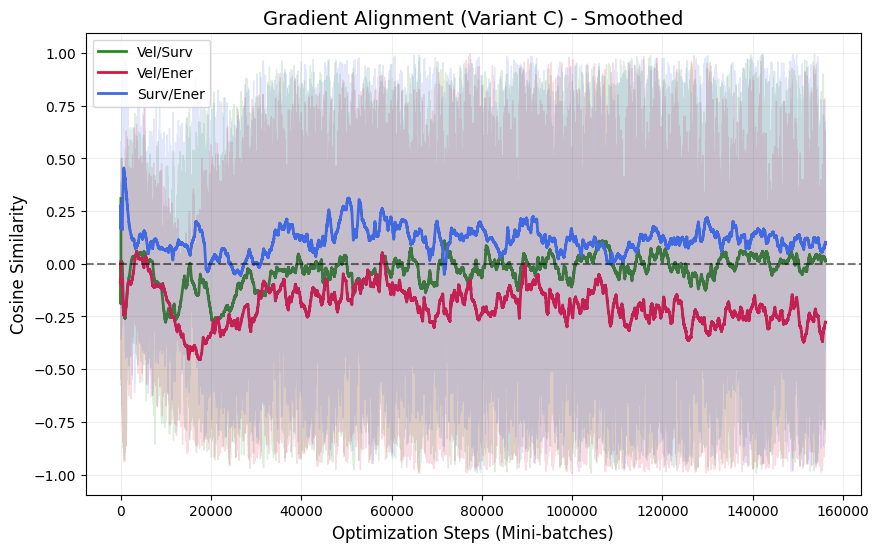

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_elegant_alignment(data_list, label, color):
    s = pd.Series(data_list)
    ema = s.ewm(span=2000).mean()

    plt.plot(s, color=color, alpha=0.15, linewidth=1)
    plt.plot(ema, color=color, label=label, linewidth=2)

plt.figure(figsize=(10, 6))

plot_elegant_alignment(history_cos_01, 'Vel/Surv', 'forestgreen')
plot_elegant_alignment(history_cos_02, 'Vel/Ener', 'crimson')
plot_elegant_alignment(history_cos_12, 'Surv/Ener', 'royalblue')

plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title("Gradient Alignment (Variant C) - Smoothed", fontsize=14)
plt.xlabel("Optimization Steps (Mini-batches)", fontsize=12)
plt.ylabel("Cosine Similarity", fontsize=12)
plt.legend()
plt.grid(alpha=0.2)
plt.show()

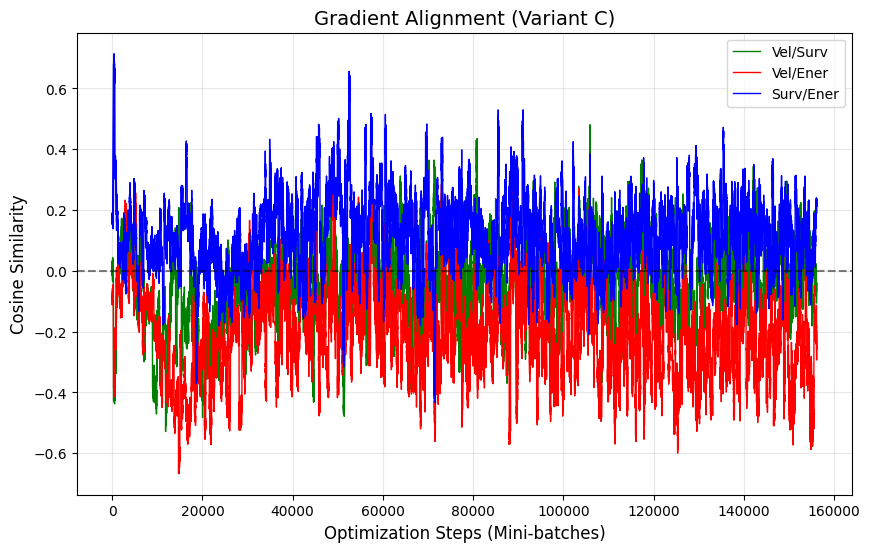

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def smooth_curve(data, window=50):
    return np.convolve(data, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10, 6))

# 01: Vel/Surv (green)
plt.plot(smooth_curve(history_cos_01), label='Vel/Surv', color='green', linewidth=1)
# 02: Vel/Ener (red)
plt.plot(smooth_curve(history_cos_02), label='Vel/Ener', color='red', linewidth=1)
# 12: Surv/Ener (blue)
plt.plot(smooth_curve(history_cos_12), label='Surv/Ener', color='blue', linewidth=1)

plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title("Gradient Alignment (Variant C)", fontsize=14)
plt.xlabel("Optimization Steps (Mini-batches)", fontsize=12)
plt.ylabel("Cosine Similarity", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

plt.show()